In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

from holoinfer.model import hologram, math

WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: Unable to get the number of gpus available: CUDA driver version is insufficient for CUDA runtime version)


Generate some test data:

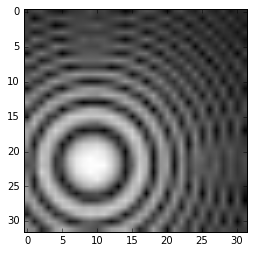

In [9]:
resolution = 32
x = y = np.linspace(0, 10, resolution)
z = 0

grid = math.cartesian(x, y, z)

illum_wavelength = 1.0
illum_wavenumber = 2*np.pi/illum_wavelength
sc_center = np.array([3, 7, 5])
sc_index = np.array([1.15, 0])
sc_radius = illum_wavelength/10

clean_data = hologram.rayleigh_gans_sphere_holo(grid, illum_wavenumber, sc_center, sc_index, sc_radius)
data = math.add_noise(clean_data)
plt.gray()
plt.imshow(data.reshape((resolution,resolution)))
plt.show()

Use pymc3 to infer position, radius, and complex index of refraction of scatterer 

In [10]:
with pm.Model() as RGScatterer:
    center = pm.Uniform('Scatterer location', lower=0, upper=10, shape=3)
    index_real = pm.Normal('Re(m)', mu=1)
    index_imag = pm.Uniform('Im(m)', lower=0, upper=1)
    index = [index_real, index_imag]
    radius = pm.Uniform('Scaterer radius', lower=illum_wavelength/100, upper=illum_wavelength)
    
    expectedvalue = hologram.rayleigh_gans_sphere_holo(grid, illum_wavenumber, center, index, radius)
    likelihood = pm.Normal('likelihood', mu=expectedvalue, sd=data.std(), observed=data)

In [11]:
with RGScatterer:
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(64, step=step, start=start)

         Current function value: -6577.526191
         Iterations: 144
         Function evaluations: 330
         Gradient evaluations: 315


  0%|                                                                                           | 0/64 [00:00<?, ?it/s]

UnboundLocalError: local variable 'strace' referenced before assignment

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000213D0F91278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000213D1172940>]], dtype=object)

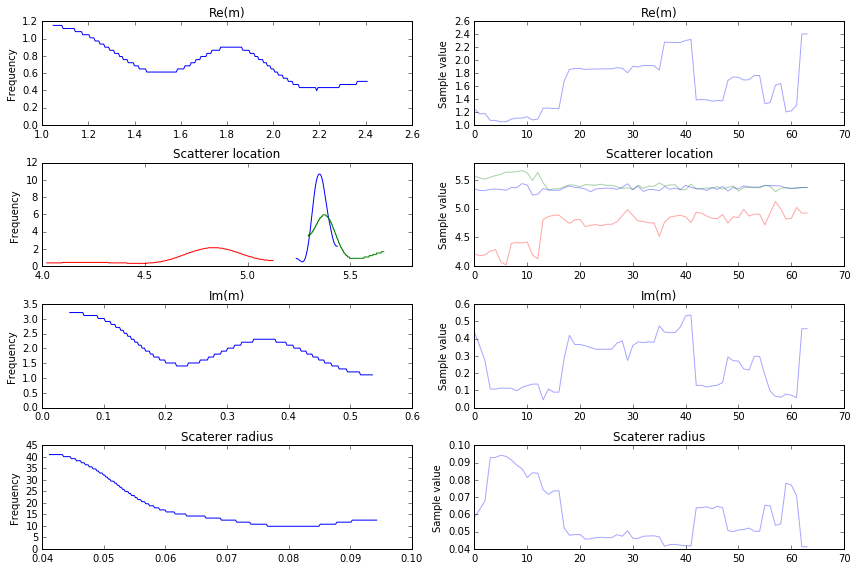

In [5]:
pm.traceplot(trace)

In [8]:
nuts_center = trace.get_values('Scatterer location').mean(axis=0)
print(nuts_center)
#nuts_n = trace.get_values('N').mean()
#print(nuts_n)

[ 5.35355121  5.42002713  4.71738846]


Below is the original hologram, the hologram with noise added (raw data), and a "reconstructed" hologram calculated from parameters inferred by pymc3 from the noisy hologram.

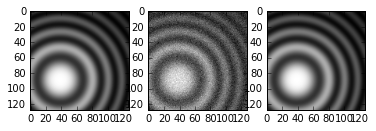

In [9]:
#plt.subplot(1, 3, 1)
#plt.imshow(clean_data.reshape((resolution, resolution)))
#plt.subplot(1, 3, 2)
#plt.imshow(data.reshape((resolution, resolution)))
#plt.subplot(1, 3, 3)
#plt.imshow(point_holo(grid, nuts_center, wavevector, nuts_n).reshape(resolution, resolution))
#plt.show()